<a href="https://colab.research.google.com/github/heyroha/DataScience/blob/main/%EC%9E%A5%EB%B9%84_%EC%9D%B4%EC%83%81%EC%A7%84%EB%8B%A8_%EB%B0%8F_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**센서 데이터 활용 장비 이상진단 및 예측**

###**1.데이터 불러오기**


In [10]:
#warning 제거
import warnings
warnings.filterwarnings('ignore')

#구글 드라이브 연결 후 경로 설정
import os
os.chdir('/content/drive/MyDrive/FASTCAMPUS/직장인 초격차/Part.3. 다양한 실무 데이터를 활용하여 실습하기 강의자료 및 부가자료/강의자료_최종본/part3_lecture_fastcampus/chapter01_센서 데이터 활용 장비 이상진단 및 예측')
os.getcwd()

'/content/drive/MyDrive/FASTCAMPUS/직장인 초격차/Part.3. 다양한 실무 데이터를 활용하여 실습하기 강의자료 및 부가자료/강의자료_최종본/part3_lecture_fastcampus/chapter01_센서 데이터 활용 장비 이상진단 및 예측'

In [11]:
import pandas as pd
df_features = pd.read_csv('chapter01_abnormal_features.csv')
df_target = pd.read_csv('chapter01_abnormal_target.csv')

In [12]:
df_features.head(2)

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0


In [13]:
df_target.head(2)

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0


###**2.문제해결 프로세스 정의**
---
>**문제정의**

```
▶ 설비 고장으로 인한 생산라인 스탑, 생산 스케줄 지연, 매출감소, 영업이익 감소
```

>**기대효과**

```
▶생산스케줄 정상화
```

>**해결방안**

```
▶데이터 기반으로 이상징후를 정의하고, 센서 데이터 모니터링을 통해 이상징후 포착 및 실시간 점검
▶session 1
- 고장이 발생하기 전 이상 증상에 대한 저으이
▶session 2
- 현업의 노하우, 경험적 지식에 기반한 rule base 이상 진단(rule base = data logic을 만드는것)
▶session 3
- 모델링을 통한 이상 증상 예측
```

>**성과측정**

```
▶이상징후 모니터링 전/후 제품 생산량, line stop 횟수 비교
```
>**현업적용**

```
▶실시간 센서 데이터 수집 및 DB적재 시스템 구축
▶서버에 데이터 모델 탑재 및 특정 시간 단위 실행 및 결과 저장
▶결과 데이터 대시보드 및 BI시스템에 출력 및 모니터링
```
>**주요코드 미리 살펴보기**

###**데이터 전처리**
---

(1) data shape확인

(2) data type 확인

(3) Null값 확인

(4) Outlier 확인


In [14]:
print(df_features.shape, df_target.shape)

(1050000, 6) (2800, 5)


In [15]:
print(df_features.info(), df_target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1050000 non-null  int64  
 1   Time    1050000 non-null  float64
 2   S1      1050000 non-null  float64
 3   S2      1050000 non-null  float64
 4   S3      1050000 non-null  float64
 5   S4      1050000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 48.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2800 non-null   int64  
 1   X       2800 non-null   float64
 2   Y       2800 non-null   float64
 3   M       2800 non-null   float64
 4   V       2800 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 109.5 KB
None None


In [16]:
print(df_features.isnull().sum())
print()
print(df_target.isnull().sum())

id      0
Time    0
S1      0
S2      0
S3      0
S4      0
dtype: int64

id    0
X     0
Y     0
M     0
V     0
dtype: int64


In [17]:
#유니크한 아이디의 개수 확인
#고유한 아이디의 개수는 동일한 것으로 보아 아이디당 다수의 데이터를 가지고 있는 것을 확
print(df_features.id.nunique())
print(df_target.id.nunique())

2800
2800


In [18]:
#하나의 제품당 0.000004초 간격으로 센서  S1~S4에 값이 수집되고 있는 상
df_features[df_features['id'] == 0].head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [19]:
#target data set 과 차원을 맞춰주기 위해서 id별로 sensor값의 평균을 사용
#data를 그룹핑하는 방법에는 다양한 방법이 있으나, 현업에서 의미있는 방법으로 데이터를 그룹핑하는 것을 추천
df_features_proc = df_features.groupby('id').mean()
df_features_proc.head()

,Time,S1,S2,S3,S4
id,,,,,
0,0.000748,-308.304553,-308.304553,1119.504719,1410.502893
1,0.000748,12780.176893,981.778780,7953.031214,-15584.755221
2,0.000748,-674.289628,-1575.681938,137.430228,-407.092340
3,0.000748,2164.216981,-11274.728589,-4221.738240,5241.350867
4,0.000748,-980.480585,-6966.912566,-2555.746810,5596.931287


In [20]:
print(df_features_proc.shape)

(2800, 5)


In [21]:
# feature data 와 target data 합치기

df_merge = pd.merge(df_features_proc, df_target, on = 'id', how = 'left')

In [22]:
df_merge.head()

,id,Time,S1,S2,S3,S4,X,Y,M,V
0,0,0.000748,-308.304553,-308.304553,1119.504719,1410.502893,0.0,-400.0,50.0,0.4
1,1,0.000748,12780.176893,981.778780,7953.031214,-15584.755221,400.0,0.0,100.0,1.0
2,2,0.000748,-674.289628,-1575.681938,137.430228,-407.092340,-300.0,-200.0,25.0,0.4
3,3,0.000748,2164.216981,-11274.728589,-4221.738240,5241.350867,200.0,-100.0,150.0,0.4
4,4,0.000748,-980.480585,-6966.912566,-2555.746810,5596.931287,-300.0,-100.0,150.0,0.4


## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 👷 (제품설계자, 장비 오퍼레이터)

```
A공장에서는 최근 도입한 장비로 인하여 골치를 썩고 있다. 새로 도입한 장비의 지속적인 고장으로 인하여 생산 스케줄을 지연되고  
있기 때문이다. 해당 장비의 특성상 한 번 고장이 나면 라인 전체를 Stop 시켜야 하므로 공정 Process에서 Bottleneck 구간이다.  
고장이 나면 공정상 막대한 손해이기 때문에 고장이 나기 전 사전 이상징후를 포착하고 점검을 통해 고장이 발생하여 미치는
손실을 줄이고자 한다.
```  

* 장비의 이상징후를 포착하기 위해 장비의 특정 위치의 충돌 센서 4개(S1~S4)를 설치하였다.
* 센서 특정 위치에 충돌이 일어나면 최종적으로 충돌 당시의 M(질량)과 V(속도)가 기록된다.
* 장비에 특정 이상의 충격(M*V)이 가해지면 장비는 정지하게 된다.

In [23]:
#시간과 X,Y축은 필요 없으므로 제거

df_merge = df_merge.drop(columns = ['Time','X','Y'])
df_merge.head()

,id,S1,S2,S3,S4,M,V
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4


###  이상(abnormal) 정의
---
* 장비가 고장나기 전에 사전 점검을 하기 위한 이상(abnormal) 현상을 정의
* 장비가 이상(abnormal)에 도달 시 사전 점검을 하기 위함

In [24]:
df_merge['MV'] = df_merge.M * df_merge.V
df_merge.head()

,id,S1,S2,S3,S4,M,V,MV
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0


충돌에너지 평균 : 60.0


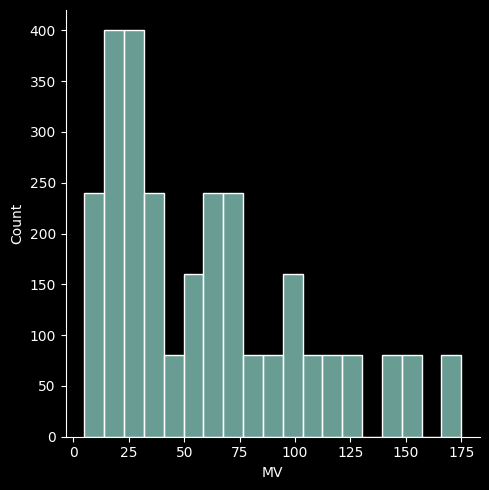

<Figure size 2000x500 with 0 Axes>

In [25]:
#이상을 정의하기 위해 MV(충돌에너지)의 분포를 확인
#대다수의 충돌에너지 data가 충돌에너지 평균인

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.displot(df_merge['MV'])
plt.figure(figsize = (20,5))
#plt.gcf().set_size_inches(20,5) ->옆으로 좀 더 길어
print('충돌에너지 평균 :', df_merge['MV'].mean())


In [26]:
# 이상을 정의하는 방법은 다양하고, 보통 현업에 기준이 존재할 확률이 큼
# 현업의 기준이 존재하지 않는다면, 보통 data의 평균에서 +_1,2,3sd (표준편차) 떨어진 data들을 이상으로 가정하는 경우가 많음
# mean +2sd 이상인 충돌 에너지를 이상으로 정의
import numpy as np
df_merge['abnormal'] = np.where(df_merge['MV'] > (df_merge['MV'].mean() + 2*df_merge['MV'].std()),1,0)
df_merge.head()

,id,S1,S2,S3,S4,M,V,MV,abnormal
0,0,-308.304553,-308.304553,1119.504719,1410.502893,50.0,0.4,20.0,0
1,1,12780.176893,981.778780,7953.031214,-15584.755221,100.0,1.0,100.0,0
2,2,-674.289628,-1575.681938,137.430228,-407.092340,25.0,0.4,10.0,0
3,3,2164.216981,-11274.728589,-4221.738240,5241.350867,150.0,0.4,60.0,0
4,4,-980.480585,-6966.912566,-2555.746810,5596.931287,150.0,0.4,60.0,0


In [27]:
df_merge['abnormal'].value_counts()

0    2640
1     160
Name: abnormal, dtype: int64

In [28]:
(160/2640) * 100

6.0606060606060606

###  이상(abnormal) 발생 시점 분석
---
* 이상(abnormal)을 정의했다면, 이상(abnormal) 시점의 센서 데이터의 분포를 탐색
* 각 센서(S1~S4)에 대해 이상(1) 상태와 이상이 아닌(0)의 상태를 비교


In [30]:
# 이상의 sensor data 분석
# 이상과 정상일대의 센서 평균값이 다른 것을 확인

print('abnormal :',df_merge[df_merge['abnormal']==1]['S1'].mean(),'normal :',df_merge[df_merge['abnormal']==0]['S1'].mean())
print('abnormal :',df_merge[df_merge['abnormal']==1]['S2'].mean(),'normal :',df_merge[df_merge['abnormal']==0]['S2'].mean())
print('abnormal :',df_merge[df_merge['abnormal']==1]['S3'].mean(),'normal :',df_merge[df_merge['abnormal']==0]['S3'].mean())
print('abnormal :',df_merge[df_merge['abnormal']==1]['S4'].mean(),'normal :',df_merge[df_merge['abnormal']==0]['S4'].mean())

abnormal : -910.6725618222317 normal : -374.457459218389
abnormal : -910.6725618222324 normal : -374.45745931738884
abnormal : -3662.427652993808 normal : -1193.247454043241
abnormal : -4473.323652485669 normal : -1431.8663172477716
